In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from Engine import Engine
from matplotlib import pyplot as plt
import xgboost

In [2]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

In [3]:
from scipy.stats import norm

# BStackGP

In [4]:
def initial(y):
    init_log_odds = sum(y==1)/y.shape[0]    
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

In [30]:
def train(X,y):
    E = Engine(Functions.simple_opset,X,y)
    for i in range(10):
        E.evolve(total_size=10,batch_size=10,
                                        elite_size=3,bins=16,beta=[0,0,0],verbose=0)
        
    return E
    

In [6]:
def gradient(E,log_odds,p,residual):
    vals = E.best[3]
    (table,width,val_max,val_min,bins) = E.best[2]

    index = ((vals - val_min)//width).astype('int32')
    index = np.where(index >= bins,bins-1,index)
    index = np.where(index < 0,0,index)
    
    # grad_bin = [sum(residual[index==i])/(sum(p[index==i]*(1-p[index==i]))) for i in range(bins)]

    p_bin = [sum(p[index==i]*(1-p[index==i]))  for i in range(bins)]
    residual_bin = [sum(residual[index==i])  for i in range(bins)]
    grad_bin = [residual_bin[i]/p_bin[i] if p_bin[i] > 0 else 0 for i in range(bins)]

    grads = np.zeros(index.shape[0])
    for i in range(bins):
        grads[index==i] = grad_bin[i]
    
    return grads,E.best[1],E.best[2],grad_bin

In [12]:
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))

    return log_odds_1,p_1

In [8]:
def predict(X,init_log_odds,init_p,stack):
    log_odds = np.array([init_log_odds for i in range(X.shape[0])])
    p = np.array([init_p for i in range(X.shape[0])])

    for param in stack:
        node,node_param,grad_bin,learning_rate = param
        
        vals = node.predict(X)
        (table,width,val_max,val_min,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(index.shape[0])
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Small datasets

In [17]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtX_train('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [26]:
train_acc = []
test_acc = []

stack = []
learning_rate = 1
init_log_odds,init_p = initial(y_train)
log_odds = np.array([init_log_odds for i in range(y_train.shape[0])])
p = np.array([init_p for i in range(y_train.shape[0])])


for i in range(1000):
    residual = y_train-p

    E = train(X_train,y_train)

    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)

    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    residual = y_train - p
    
    
    loss = sum(residual**2)
    if not np.isnan(loss):
        stack.append((node,node_param,grad_bin,learning_rate))
        
        pred = p > 0.5
        train_acc.append(accuracy_score(y_train,pred))
        
        pred = predict(X_test,init_log_odds,init_p,stack)
        pred = pred > 0.5
        test_acc.append(accuracy_score(y_test,pred))
    
    else:
        break
    print(loss)

pred = p > 0.5
print(classification_report(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,stack)
pred = pred > 0.5
print(classification_report(y_test,pred))

34.70872171281756
34.69606003240092
34.694725203463975
34.69368220684423
34.69368183340375
33.46953593218015
32.82607407515191
32.775859335907136
32.66185016855222
29.50027855496777
29.483158797383783
23.753690145136257
23.696722151787494
23.696736654039587
23.69686913955891
23.412530609150416
23.332521727041247
23.343582852000083
23.352778584335084
23.35363023029688
22.223667845044076
22.286128281628557
22.210697740184614
21.151270926252867
21.13328219932213
21.034836356867995
21.015246857564655
21.083070224028763
21.106208626359606
21.106102438649053
21.099048210165137
20.93061465992111
20.90767925592509
20.907284537723523
20.92274949947922
20.893056756148706
20.8526501642447
20.86228865716823
20.71266375214237
20.712495248514518
20.711946473188537
20.613430385460997
20.65544752485835
20.682644702513144
20.686369243280236
20.670630150284733
20.684238587602447
20.68421082887202
20.73700714126159
20.73876587939832
20.738765249070042
20.721293177001154
20.41834344668844
20.4403431628705

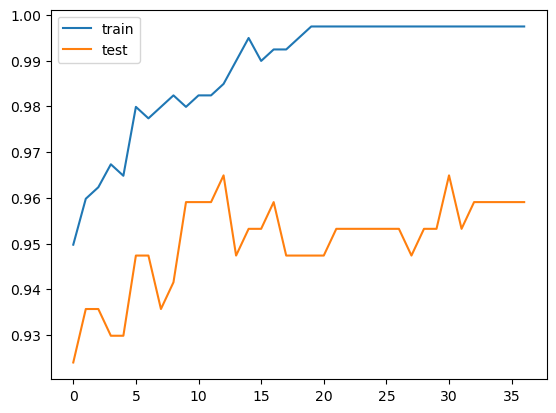

In [159]:
# bcw
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

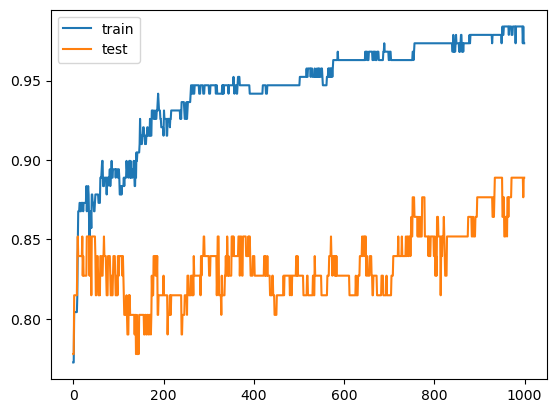

In [74]:
# heart
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

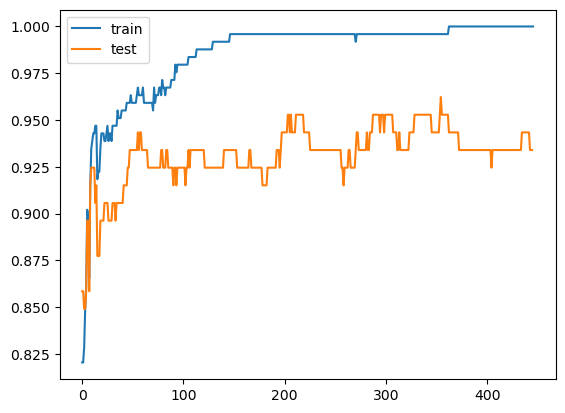

In [78]:
# iono
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

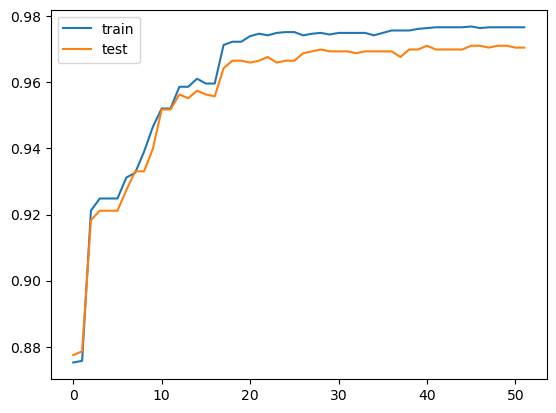

In [150]:
# parks
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

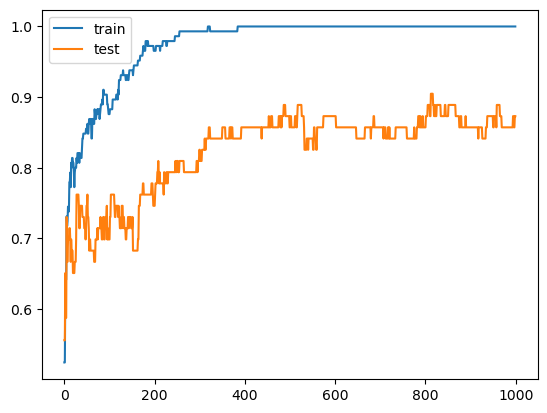

In [33]:
# sonar
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

# Higgs Boson

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

df = pd.read_csv('../data/HIGGS.csv',header=None)
data_X = df.iloc[:,1:].to_numpy()
data_y = df.iloc[:,0].to_numpy().astype('int')

In [14]:
X_train,X_test2,y_train,y_test2 = train_test_split(data_X,data_y,test_size=500000)
Xs,ys = shuffle(X_train,y_train)

In [15]:
i = 105000
j = 10500

X_train = Xs[:i]
y_train = ys[:i]

X_test = Xs[i:i+j]
y_test = ys[i:i+j]

In [16]:
init_log_odds,init_p = initial(ys)

In [31]:
train_acc = []
test_acc = []

stack = []
learning_rate = 0.5

log_odds = np.array([init_log_odds for i in range(y_train.shape[0])])
p = np.array([init_p for i in range(y_train.shape[0])])

test_log_odds = np.array([init_log_odds for i in range(y_test.shape[0])])
test_p = np.array([init_p for i in range(y_test.shape[0])])

for g in range(10000):
    start = time()
    residual = y_train-p
    E = train(X_train,y_train)
    grads,node,node_param,grad_bin = gradient(E,log_odds,p,residual)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = sum(residual**2)
    running_time = time() - start

    # need_more_train_index = p < 0.99
    # X_train = X_train[need_more_train_index]
    # y_train = y_train[need_more_train_index]
    # log_odds = log_odds[need_more_train_index]
    # p = p[need_more_train_index]
    
    test_residual = y_test-test_p
    
    test_vals = node.predict(X_test)
    (table,width,val_max,val_min,bins) = node_param

    index = ((test_vals - val_min)//width).astype('int32')
    index = np.where(index >= bins,bins-1,index)
    index = np.where(index < 0,0,index)
    
    test_grads = np.zeros(index.shape[0])
    for i in range(bins):
        test_grads[index==i] = grad_bin[i]
    
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)

    test_loss = sum(test_residual**2)

    if not np.isnan(loss):
        stack.append((node,node_param,grad_bin,learning_rate))

        pred = p > 0.5
        train_acc.append(accuracy_score(y_train,pred))
        # pred = p
        # train_acc.append(roc_auc_score(y_train,pred))
        
        pred = test_p > 0.5
        test_acc.append(accuracy_score(y_test,pred))
        # pred = test_p
        # test_acc.append(roc_auc_score(y_test,pred))
        print("Generation:",g,loss,test_loss,train_acc[-1],test_acc[-1],str(round(running_time,3))+'s')
        
    else:
        break

Generation: 0 27259.232029337007 2735.763269494994 0.5573714285714285 0.5516190476190476 2.33s
Generation: 1 25638.79601810898 2578.1597632207013 0.605247619047619 0.5956190476190476 2.323s
Generation: 2 24909.650509699328 2507.873626785665 0.6179619047619047 0.6140952380952381 2.31s
Generation: 3 24418.424629368787 2460.6563369596747 0.6139333333333333 0.6097142857142858 2.302s
Generation: 4 24297.02440359535 2448.955994417142 0.6210571428571429 0.6182857142857143 2.43s
Generation: 5 24007.27053813506 2413.192301984586 0.6238190476190476 0.6227619047619047 2.354s
Generation: 6 23872.660375781383 2402.0258341702142 0.6286 0.6276190476190476 2.378s
Generation: 7 23606.07421598613 2378.7122722315785 0.6320857142857143 0.6289523809523809 2.354s
Generation: 8 23494.586813828762 2364.7208514397357 0.6352952380952381 0.6317142857142857 2.381s
Generation: 9 23347.275921650365 2352.7424604085595 0.6368095238095238 0.6310476190476191 2.295s
Generation: 10 23281.484369817208 2349.211043526684 0.

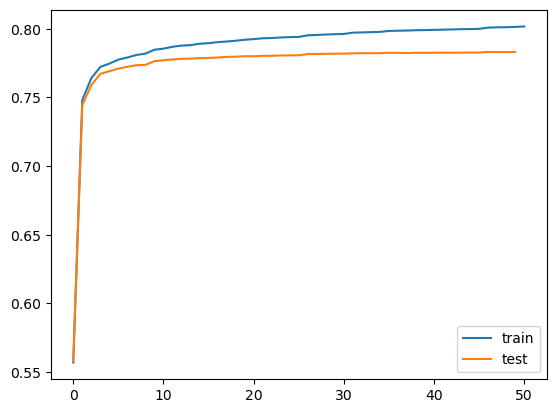

In [24]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

In [23]:
pred = predict(X_train,init_log_odds,init_p,stack)
roc_auc_score(y_train,pred)

0.794601670766857

In [24]:
pred = predict(X_test,init_log_odds,init_p,stack)
roc_auc_score(y_test,pred)

0.7794890038894511

In [35]:
pred = predict(Xs[-500000:],init_log_odds,init_p,stack)
roc_auc_score(ys[-500000:],pred)

0.7740137509405702

In [37]:
Xs.shape

(10500000, 28)

# Cover Type